# Homework 02
### [Chia-Chun Chao]

In [1]:
# (do not modify this cell)

# allowed imports only (you may not need all of these)
import sys, os
import glob
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

# make plots stay inside the notebook
%matplotlib inline

# Functions

#### 2\. Error reports have been gathered from a variety of different reporting systems, so not all reports follow the same format. Create a function called `load_report` where indicated that takes a report filename as input, reads the text of that file into Python, then extracts and returns the error mode counts as a Python dictionary.

In [2]:
def load_report(filename):
    """
    This function takes a report filename as input, 
    reads the text of that file into Python, 
    then extracts and returns the error mode counts as a Python dictionary.
    It also checks if the filename is the same as DATACENTER number and if counts are integers.
    """
    reportText = open(filename).read() #Read the file 
    dataCenterDict = {}
       
    for line in reportText.split('\n'): #Process every line
        splitLineByColon = line.split(':') #Check if this line is one of error modes
        
        try: #If the string after a colon is a number, it is a count
            count = int(splitLineByColon[1].strip())
        except IndexError: #There is no colon in this line
            #Check if DATACENTER number is the same as file number
            if "DATACENTER" in splitLineByColon[0]: #Check if this line is DATACENTER number
                fileNumber = filename.split('/')[-1].replace(".dat", '') #Get rid of all characters except file number
                if splitLineByColon[0].replace("DATACENTER ", '') != fileNumber:
                    print(fileNumber, ".dat contains a different DATACENTER number.")                   
            continue
        except ValueError: #The second item is not a number, so this line could be AUTOMATED REPORT PERIOD or OPERATION NOTES
            continue
             
        #Check if count is integer
        if(splitLineByColon[1].strip().isdigit() == False):
            print("The error mode count in", filename, "is not an integer.")
            
        #Add this error mode and count to the dictionary of this datacenter
        dataCenterDict[splitLineByColon[0]] = count
    
    return dataCenterDict

In [3]:
def total_report(dataCenterListOfDict):
    """
    This function calculates total count of each error mode in all reports.
    Also, it calculates the number of times each error mode is recorded in a file.
    """
    totalErrorCountDict = {}
    errorModeInFileDict = {}
    
    for dataCenter in range(0, len(dataCenterListOfDict)): #Loop for every data center
        for errorMode in dataCenterListOfDict[dataCenter]: #Loop for every error mode in a data center
            #Store the count in the dictionary
            try: #Add the count to the dictionary
                totalErrorCountDict[errorMode] += dataCenterListOfDict[dataCenter][errorMode] 
                errorModeInFileDict[errorMode] += 1 #Increase the number of times that this error mode appears
            except KeyError: #First time seeing this error mode
                totalErrorCountDict[errorMode] = dataCenterListOfDict[dataCenter][errorMode] 
                errorModeInFileDict[errorMode] = 1
                
    return totalErrorCountDict, errorModeInFileDict

In [4]:
def print_error_mode_dictionary(dictionary):
    """
    Print all items in the dictionary in a formatted way.
    """
    for errorMode in dictionary:
        print("{0:34}{1:7d}".format(errorMode, dictionary[errorMode]))
    print("------------------------------------------------------")
    pass

In [5]:
def check_ID_consistency(IDList):   
    """
    Measure ID consistency by checking if ID numbers are unique and if they are sequential or if there are gaps of missing ID numbers.
    """
    sequential=0
    for ID in IDList:
        IDNumber = int(ID)
        if IDNumber == sequential:
            sequential += 1
        elif IDNumber < sequential: #If sequential increases faster than ID, there are more than one file with the same ID
            print(ID, "is not unique.")
            sequential += 1
        else: #If sequential increases slower than ID, some IDs are missing
            print(sequential, "is missing, so ID numbers are not sequential.")
    pass

In [6]:
def check_error_mode_consistency(errorModeInFileDict, fileCount):
    """
    Measure error modes consistency by checking if all reports contains the same error modes.
    """
    differentModeNameList = []
    for errorMode in errorModeInFileDict: #errorModeInFileDict stores the number of files each error mode appears in
        #If the error modes consistent, the number of files each error mode appears in should equal the count of files
        if errorModeInFileDict[errorMode] != fileCount:   
            differentModeNameList.append(errorMode) #Store the error modes that might refer to the same error mode

    #Not all files contain these error modes, which means they might represent the same error mode.
    if len(differentModeNameList) != 0: 
        print("The number of times each error mode is recorded in a file:\n")
        print_error_mode_dictionary(errorModeInFileDict)      
        print("Not all files contain these error modes. They might represent the same error mode.")

    return differentModeNameList


In [7]:
def merge_error_modes(differentModeNameList, totalErrorCountDict, dataCenterListOfDict):
    """
    Merge repeated different error modes into one.
    """
    newCount = 0
    newErrorMode = ""
    print("Merge these error modes into one:\n")
    
    for errorMode in differentModeNameList: #Print and merge repeated error modes into one 
        print(errorMode)
        newCount += totalErrorCountDict[errorMode] #Calculate correct error mode count after merging some modes
        newErrorMode = newErrorMode + errorMode + " / "
        del totalErrorCountDict[errorMode]

    newErrorMode = newErrorMode[:-3]
    totalErrorCountDict[newErrorMode] = newCount
    print("------------------------------------------------------")
    
    #Update the name of merged error mode in each report
    for datacenter in range(0,len(dataCenterListOfDict)): #Loop for every dictionary storing error mode counts
        for errorMode in differentModeNameList: #Find the error mode that needs to be updated
            if errorMode in dataCenterListOfDict[datacenter]:
                #Copy the count to the merged error mode
                dataCenterListOfDict[datacenter][newErrorMode] = dataCenterListOfDict[datacenter][errorMode]
                del dataCenterListOfDict[datacenter][errorMode] #Delete the old error mode
                break
        
    return totalErrorCountDict

In [8]:
def analyze_total_count_of_Each_center(dataCenterListOfDict):
    """
    For every data center, summarize total count of each error mode and store counts in a dictionary.
    Find top 10 data centers that experience more errors than others
    """
    totalCountOfEachDataCenterDict = {}
    for dataCenter in range(0, len(dataCenterListOfDict)): #Iterate over all dictionary for every data center
        totalCount = 0
        #Summarize all counts of error modes
        totalCountOfEachDataCenterDict[dataCenter] = sum(dataCenterListOfDict[dataCenter].values())
    
    #Find top 10 data centers that experience more errors than others
    top10 = 0
    print("Total errors of these 10 data centers that experience more errors than others:\n")
    for dataCenter in sorted(totalCountOfEachDataCenterDict, key=totalCountOfEachDataCenterDict.get, reverse=True):
        print("DATACENTER {0:06d}{1:20d}".format(dataCenter, totalCountOfEachDataCenterDict[dataCenter]))
        top10 += 1
        if top10 == 10:
            break                
    print("------------------------------------------------------")
    
    return totalCountOfEachDataCenterDict

In [9]:
def find_average_number_of_errors(totalCountOfEachDataCenterDict):
    """
    Find the typical number of errors a data center should expect.
    """
    print("The typical number of errors a data center should expect:\n")
    print("Total count of errors in each data center / Number of data centers")
    total = sum(totalCountOfEachDataCenterDict.values())
    number = len(totalCountOfEachDataCenterDict)
    print(total, '/', number, '=', total/number)
    
    print("------------------------------------------------------")
    pass

In [10]:
def find_most_common_error(dataCenterListOfDict):
    """
    Find the number of data centers that experience each error, which means the count is not 0.
    """
    errorModeOccurInFileDict = {} #A dictionary storing the number of files each error mode occurs in
    for dataCenter in dataCenterListOfDict:
        for errorMode in dataCenter:
            if dataCenter[errorMode] != 0: #This error occurs in this data center
                try: #Increase the count of this error mode
                    errorModeOccurInFileDict[errorMode] += 1
                except KeyError: #First time seeing this error mode
                    errorModeOccurInFileDict[errorMode] = 1

    #Find the error mode that occurs in the most data centers
    print("The number of times each error mode occurs in a data center (", len(dataCenterListOfDict), " data centers in total):\n", sep='')
    for errorMode in sorted(errorModeOccurInFileDict, key=errorModeOccurInFileDict.get, reverse=True):
        print("{0:34}{1:7d}{2:10.2%}".format(errorMode, errorModeOccurInFileDict[errorMode], errorModeOccurInFileDict[errorMode]/len(dataCenterListOfDict)))
    
    print("------------------------------------------------------")
    
    pass

In [11]:
def find_errors_distribution(totalCountOfEachDataCenterDict):
    """
    Find the distribution of the number of errors a data center experiences using histograms.
    After showing the graphs, the result shows the typical number is 0 to 25.
    """
    #Find the distribution of the number of errors a data center experiences using histograms
    print("Find the distribution of the number of errors a data center experiences.")
    print("Construct a histogram showing the distribution of total errors that data centers experience.")
    
    plt.hist(list(totalCountOfEachDataCenterDict.values()), bins = 20)
    plt.title("Histogram without setting the range")
    plt.xlabel("Number of errors")
    plt.ylabel("Count of numbers in a range")
    plt.show()
    print("Most results seem very small, so we set the upper limit to 200.")
    plt.hist(list(totalCountOfEachDataCenterDict.values()), bins = 20, range=[0,200])
    plt.title("Histogram with range 0 to 200")
    plt.xlabel("Number of errors")
    plt.ylabel("Count of numbers in a range")
    plt.show()

    #Calculate the number of data centers that experience less than or equal to 25 errors
    count = 0
    for dataCenter in sorted(totalCountOfEachDataCenterDict, key=totalCountOfEachDataCenterDict.get): #Iterate over all dictionary for every data center
        if totalCountOfEachDataCenterDict[dataCenter] > 25:
            break
        count += 1
    print("In", len(totalCountOfEachDataCenterDict), "data centers, there are", count, "data centers experience 0 to 25 errors.")
    print(count, '/', len(totalCountOfEachDataCenterDict), ' = ', sep='', end='')
    print("{:.2%}".format(count/len(totalCountOfEachDataCenterDict)))
    
    print("------------------------------------------------------")

In [12]:
def find_errors_not_occur(totalErrorCountDict):
    """
    Find the error modes that do not occur in all data centers
    """
    print("These errors do not happen in all data centers:\n")
    for errorMode in totalErrorCountDict:
        if totalErrorCountDict[errorMode] == 0:
            print (errorMode)
    
    print("------------------------------------------------------")
    pass

In [13]:
def find_most_error_for_a_center(dataCenterListOfDict):
    """
    For each data center, find the error mode that it experiences the most.
    """
    dataCenterMostErrorDict = {}
    for dataCenter in range(0, len(dataCenterListOfDict)):
        #Find the the error mode that this data center experiences the most
        errorMode = max(dataCenterListOfDict[dataCenter], key=dataCenterListOfDict[dataCenter].get)
        try:
            dataCenterMostErrorDict[errorMode].append(dataCenter)
        except KeyError: #First time seeing this error mode
            dataCenterMostErrorDict[errorMode] = []
            dataCenterMostErrorDict[errorMode].append(dataCenter)        
    
    del dataCenterMostErrorDict["Misc. elec."]
    print("Below is the main issue of each data center (the rest are all Misc. elec.):\n")
    print(dataCenterMostErrorDict)
    print("------------------------------------------------------")
    pass    
        

In [14]:
def print_error_total_proprotion(errorDictionary, totalDictionary, proportionDictionary, flag, number):
    """
    Print data centers with more errors related to water.
    """
    limit = 0
    print("             ID       error     total   proportion")   
    if flag == 0: #Sort data centers by the count of water error
        for dataCenter in sorted(errorDictionary, key=errorDictionary.get, reverse=True):
            print("DATACENTER {0:06d}{1:10d}{2:10d}{3:10.2%}".format(dataCenter, errorDictionary[dataCenter], totalDictionary[dataCenter], proportionDictionary[dataCenter]))
            limit += 1
            if limit == number:
                break     
                
    elif flag == 1: #Sort data centers by the proportion of water error
        for dataCenter in sorted(proportionDictionary, key=proportionDictionary.get, reverse=True):
            print("DATACENTER {0:06d}{1:10d}{2:10d}{3:10.2%}".format(dataCenter, errorDictionary[dataCenter], totalDictionary[dataCenter], proportionDictionary[dataCenter]))
            limit += 1
            if limit == number:
                break              
                
    print("------------------------------------------------------")    
    pass

In [15]:
def wilson_lower_confidence(num, pos, z=1.96):
    """`num` samples, `pos` of which are positive = true = 1. The rest 
    are negative = false = 0. `z` is the normal proportion for confidence
    interval, default z = 1.96 (95%)
    """
    n = num
    if n == 0:
        return 0

    p = pos / n # observed rate p
    #return (p + z*z/(2*n) - z*math.sqrt((p*(1-p) + z**2/(4*n))/n)) / (1 + z**2/n)
    return (p + z*z/(2*n) - z*(((p*(1-p) + z**2/(4*n))/n)**(1/2))) / (1 + z**2/n)

# Problem 1: Processing error reports


#### 3\. Write a loop that calls your function on each report file and stores the error mode counts in an appropriate data structure.  Since different reports may look very different, you need to examine the report files both computationally (by writing and rewriting Python code) and by eye (by reading the text files yourself) to determine how the reports are written. **Your function must automatically read all reports correctly**.

In [16]:
"""
Write a loop that calls your function on each report file and stores the error mode counts in an appropriate data structure. 
"""
#Initiate variables
fileCount = 0 #Number of files in reports/
IDList = [] #Store file numbers that have been read
dataCenterListOfDict = [] #A list contains every datacenter and each item represents a dictionary storing a dictionary

path = os.getcwd() + "/reports/" #Get the path of current directory and enter to reports/

for filename in os.listdir(path): #Process all file in reports/
    IDList.append(filename.replace(".dat", '')) #Store the ID into a list for later check
    filename = path + filename #Get the entire path of the file
    #totalErrorCountDict, errorModeInFileDict, dataCenterListOfDict = load_report(filename, totalErrorCountDict, errorModeInFileDict, dataCenterListOfDict)
    dataCenterListOfDict.append(load_report(filename))
    fileCount += 1 #Count the number of all files in reports/

#### 4\. It appears that data centers have associated ID numbers. Are these IDs **consistent**? How should we define consistency? One way is to check if ID numbers are unique and if they are sequential or if there are gaps of missing ID numbers. How else should we define and measure consistency?

We can describe an ID as consistent if this ID is expectable, which means we can correctly guess next ID by current ID as long as next ID exists. To check if ID numbers are unique and sequential, `check_ID_consistency` compares IDs with a continuous number starting from 0 to check if they match. If there are same IDs or missing IDs, the function will show messages. Also, in `load_report`, there is an `if` statement to check if DATACENTER number in a file is the same as the file name. Above two methods both do not show any messages, so these IDs are consistent.

In [17]:
#Check if ID numbers are unique and if they are sequential or if there are gaps of missing ID numbers.
check_ID_consistency(sorted(IDList)) 

#### 5\. Are the **error modes** consistent? Do you need to do any cleaning, such as merging different error mode names that represent the same thing or fixing typos in the names of error modes? **[Bonus for ugrads/Required for grads]**: Make the error modes consistent or prove they are already consistent.

No, these error modes are not consistent. Depending on the number of times each error mode is recorded in a file, `check_error_mode_consistency` shows that HVAC, Air Con., and A/C are not recorded in all 1431 files. Because the sum of these three is equal to 1431, we assume HVAC, Air Con., and A/C all refer to the same error mode. Therefore, we update a new error mode count after merging these three error modes in `merge_error_modes`. 

In [18]:
#totalErrorCountDict = {} #A dictionary storing total count of each error mode
#errorModeInFileDict = {} #A dictionary storing the number of files each error mode appears in    
totalErrorCountDict, errorModeInFileDict = total_report(dataCenterListOfDict)

#Check if all reports contains the same error modes
differentModeNameList = check_error_mode_consistency(errorModeInFileDict, fileCount) 

#If there are different error modes refering to the same error mode, merge repeated error modes into one.
if len(differentModeNameList) != 0:
    totalErrorCountDict = merge_error_modes(differentModeNameList, totalErrorCountDict, dataCenterListOfDict)

    print("Below is the new error mode dictionary:\n")
    print_error_mode_dictionary(totalErrorCountDict)

The number of times each error mode is recorded in a file:

Fiber pipeline in                    1431
Fiber pipeline out                   1431
HVAC                                  941
Misc. elec.                          1431
Operator (employee) error            1431
Operator (non-employee) error        1431
Physical intrusion (person)          1431
Physical intrusion (water)           1431
Power/generator loss                 1431
Power/generator reduction            1431
Air Con.                              200
A/C                                   290
------------------------------------------------------
Not all files contain these error modes. They might represent the same error mode.
Merge these error modes into one:

HVAC
Air Con.
A/C
------------------------------------------------------
Below is the new error mode dictionary:

Fiber pipeline in                   42601
Fiber pipeline out                  12237
Misc. elec.                        214269
Operator (employee) err

#### 6\. Are the error mode **counts** consistent? Define consistency and show if the counts are or are not consistent? If they are not consistent, make them consistent.

In `load_report`, after extracting each line and get the item after a colon, we should get a count for that error mode in the line. Also, this count should be an integer, so `isdigit()` checks if this count is an integer or a float number. After execution, there is no any message showing the count is not an integer, so the error mode counts are consistent.


# Problem 2: Error rates and statistics

#### 1\. Analyze these counts to report what are the different error modes and how often they occur. Do some data centers experience more errors than others? What is the typical number of errors a data center should expect? What are the most common types of errors experienced by data centers? Ask and answer at least two more questions of these data! 
##### You should summarize the counts using basic statistics and visualizations. Craft an appropriate argument to help your manager and the company's risk assessment office understand what is happening at the data centers.

* According to the result, there are 10 error modes and the result shows total times of each error in all reports.
* Data center 000223 and 000353 experience the most errors and their counts are even more than three times of data center 000959, which means these two data center might have some problems. 
* The typical number of errors that a data center should expect is the average number of errors that a data center experience, so we divide the total counts by the number of data centers and get 262 as the typical number.
* The most common types of errors experienced by data centers is Misc. elec., which occurs in 99.79% of data centers. 
* As shown in histograms, numbers of total errors that data centers experience distribute in 0 to 25 mostly. 
* Operator (employee) error and Power/generator loss do not happen in all data centers, so they might not be issues for a data center, or they might be serious problems that are essential to record but barely happen.
* Most data centers experience the error mode, Misc. elec., the most, but there are still some data centers have other main issues.

Total counts of each error mode in all data centers:

Fiber pipeline in                   42601
Fiber pipeline out                  12237
Misc. elec.                        214269
Operator (employee) error               0
Operator (non-employee) error        4489
Physical intrusion (person)           617
Physical intrusion (water)          50684
Power/generator loss                    0
Power/generator reduction            7762
HVAC / Air Con. / A/C               42563
------------------------------------------------------
Total errors of these 10 data centers that experience more errors than others:

DATACENTER 000223              111967
DATACENTER 000353              105275
DATACENTER 000959               28322
DATACENTER 001357               14999
DATACENTER 000841               12979
DATACENTER 001386               11777
DATACENTER 001035                8386
DATACENTER 001176                6920
DATACENTER 001092                4592
DATACENTER 000159                4057
-----------

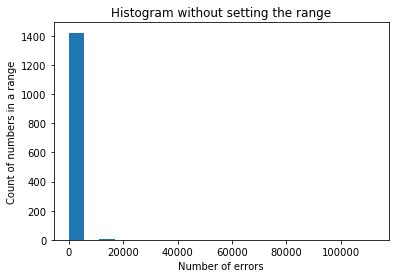

Most results seem very small, so we set the upper limit to 200.


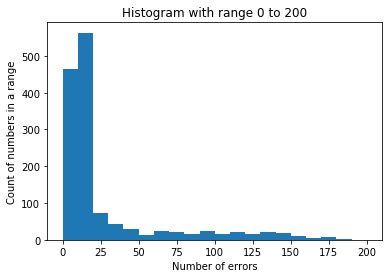

In 1431 data centers, there are 1082 data centers experience 0 to 25 errors.
1082/1431 = 75.61%
------------------------------------------------------
These errors do not happen in all data centers:

Operator (employee) error
Power/generator loss
------------------------------------------------------
Below is the main issue of each data center (the rest are all Misc. elec.):

{'Fiber pipeline in': [5, 22, 231, 262, 291, 320, 326, 344, 372, 400, 475, 478, 488, 503, 531, 585, 603, 605, 617, 638, 715, 720, 736, 805, 848, 874, 886, 919, 944, 1006, 1024, 1040, 1045, 1154, 1177, 1214, 1217, 1231, 1302], 'Physical intrusion (water)': [11, 12, 16, 26, 28, 36, 52, 59, 61, 64, 68, 86, 92, 118, 130, 139, 140, 141, 154, 156, 168, 173, 195, 201, 203, 229, 241, 245, 254, 278, 288, 295, 314, 325, 332, 339, 358, 359, 373, 383, 398, 412, 413, 414, 439, 444, 447, 451, 458, 482, 496, 499, 518, 521, 528, 533, 579, 597, 614, 619, 621, 633, 648, 654, 658, 670, 677, 678, 683, 697, 700, 710, 711, 723, 731, 73

In [19]:
print("Total counts of each error mode in all data centers:\n")
print_error_mode_dictionary(totalErrorCountDict)
    
#Find top 10 data centers that experience more errors than others
totalCountOfEachDataCenterDict = analyze_total_count_of_Each_center(dataCenterListOfDict)

#Find the typical number of errors a data center should expect
find_average_number_of_errors(totalCountOfEachDataCenterDict)

#Find the number of data centers that experience each error, which means the count is not 0
find_most_common_error(dataCenterListOfDict)

#Find the distribution of the number of errors a data center experiences using histograms
find_errors_distribution(totalCountOfEachDataCenterDict)

#Find the error modes that do not occur in all data centers
find_errors_not_occur(totalErrorCountDict)

#For each data center, find the error mode that it experiences the most
find_most_error_for_a_center(dataCenterListOfDict)
 

#### 2\. Being very careful as you interpret your analyses, what are the **riskiest** error modes in terms of shutting down data centers?

Operator (employee) error and Power/generator loss do not happen in all data centers, so they might be serious problems that are essential to record but barely happen, or whenever they happen, the data center will not be able to send a report. 

# Problem 3: Flood risk

#### 1\. From the error reports, what data centers are most at risk due to flooding? Are some more at risk than others or is the risk of floods about the same across data centers. To answer this question, look at errors related to water compared with overall error rates. What proportion of the errors at each data center is due to water?

To determine a data center at risk due to flooding, we can compare the error by the number or by the proportion. In terms of the count, 001357, 000223, 000353 experience much more errors than other data centers. In terms of proportion, the histogram shows that most proportions of data centers are lower than the overall proportion, but there are still a large number of data centers have higher proportion of water error than others, which means they may be more at risk than most data centers. Data center 001357 has the highest number of water errors, and its proportion is 65.22%, which is really high compared to the overall proportion. The proportion of water-related error in all data centers is 13.51%. The average proportion of water-related error in each data centers is 14.32%.

These 10 data centers encounter errors related to water more than others:

             ID       error     total   proportion
DATACENTER 001357      9782     14999    65.22%
DATACENTER 000223      9497    111967     8.48%
DATACENTER 000353      9075    105275     8.62%
DATACENTER 000959      2476     28322     8.74%
DATACENTER 000841      1088     12979     8.38%
DATACENTER 001386       996     11777     8.46%
DATACENTER 001035       737      8386     8.79%
DATACENTER 001176       559      6920     8.08%
DATACENTER 001092       405      4592     8.82%
DATACENTER 000154       389       572    68.01%
------------------------------------------------------


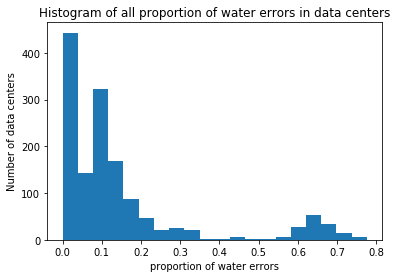

These 10 data centers encounter errors related to water more than others in proportion:

             ID       error     total   proportion
DATACENTER 000499        45        58    77.59%
DATACENTER 001076       107       141    75.89%
DATACENTER 001281        66        87    75.86%
DATACENTER 000229        87       117    74.36%
DATACENTER 000700        60        81    74.07%
DATACENTER 000856        50        68    73.53%
DATACENTER 000412        83       113    73.45%
DATACENTER 000156        83       114    72.81%
DATACENTER 000451        58        80    72.50%
DATACENTER 000141        45        63    71.43%
------------------------------------------------------
The proportion of water-related error in all data centers is:

Total water errors / all types of errors
50684 / 375222 = 13.51%

The average proportion of water-related error in each data centers is:

204.85187529160706 / 1431 = 14.32%
------------------------------------------------------


In [20]:
#Store the error count related to water for every data center
waterErrorCountDict = {}
waterErrorProportionDict = {}
for dataCenter in range(fileCount):
    waterErrorCountDict[dataCenter] = dataCenterListOfDict[dataCenter]["Physical intrusion (water)"]
    waterErrorProportionDict[dataCenter] = waterErrorCountDict[dataCenter]/totalCountOfEachDataCenterDict[dataCenter]
    
#Print the top 10 data centers that encounter more errors related to water   
print("These 10 data centers encounter errors related to water more than others:\n")
print_error_total_proprotion(waterErrorCountDict, totalCountOfEachDataCenterDict, waterErrorProportionDict, 0, 10)

#Find the distribution of proportion of water errors in all data centers
plt.hist(list(waterErrorProportionDict.values()), bins = 20)
plt.title("Histogram of all proportion of water errors in data centers")
plt.xlabel("proportion of water errors")
plt.ylabel("Number of data centers")
plt.show()
#Print the top 10 data centers that encounter more proportion of errors related to water   
print("These 10 data centers encounter errors related to water more than others in proportion:\n")
print_error_total_proprotion(waterErrorCountDict, totalCountOfEachDataCenterDict, waterErrorProportionDict, 1, 10)

#Total counts of Physical intrusion (water) in all data centers
print("The proportion of water-related error in all data centers is:\n")
print("Total water errors / all types of errors")
print(totalErrorCountDict["Physical intrusion (water)"], '/', sum(totalErrorCountDict.values()), '=', "{0:.2%}".format(totalErrorCountDict["Physical intrusion (water)"]/sum(totalErrorCountDict.values())))  

print("\nThe average proportion of water-related error in each data centers is:\n")
print(sum(waterErrorProportionDict.values()), '/', len(waterErrorProportionDict), '=', "{0:.2%}".format(sum(waterErrorProportionDict.values())/len(waterErrorProportionDict)))  

print("------------------------------------------------------")    


#### 2\. Rank the  N  data centers according to flood risk, from a rank of  R=1  (most at risk) to  R=N  least at risk. Develop a visualization or other data presentation to display this information compactly. **[Bonus for ugrads/Required for grads]**: When ranking of data centers according to flood risk, incorporate uncertainty in your risk proportions. Determine how best to do this, and **justify** your analysis choices.

To incorporate uncertainty in the risk proportions, we can use Wilson score test and rank on the Wilson lower bound by smoothing Wald approximation.


Rank the data centers according to flood risk with incorporating uncertainty:

             ID       error     total   proportion
DATACENTER 001076       107       141    68.20%
DATACENTER 001281        66        87    65.90%
DATACENTER 000229        87       117    65.76%
DATACENTER 000499        45        58    65.34%
DATACENTER 000412        83       113    64.64%
DATACENTER 001357      9782     14999    64.45%
DATACENTER 000154       389       572    64.08%
DATACENTER 000156        83       114    64.00%
DATACENTER 000700        60        81    63.60%
DATACENTER 000140       280       414    62.98%
DATACENTER 000028        94       132    62.97%
DATACENTER 001317       112       159    62.93%
DATACENTER 001247       108       155    62.04%
DATACENTER 000856        50        68    61.99%
DATACENTER 000061       102       146    61.99%
DATACENTER 000785        90       128    61.90%
DATACENTER 000451        58        80    61.86%
DATACENTER 000068       341       518    61.64%
DATACE

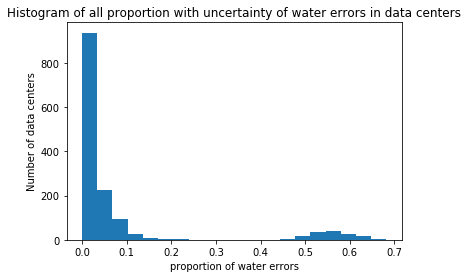

In [21]:
waterErrorUncertaintyProportionDict = {}
for dataCenter in range(fileCount):
    waterErrorUncertaintyProportionDict[dataCenter] = wilson_lower_confidence(totalCountOfEachDataCenterDict[dataCenter], waterErrorCountDict[dataCenter])   

#Rank the N data centers according to flood risk with incorporating uncertainty
print("Rank the data centers according to flood risk with incorporating uncertainty:\n") 
print_error_total_proprotion(waterErrorCountDict, totalCountOfEachDataCenterDict, waterErrorUncertaintyProportionDict, 1, 20)
    
#Find the distribution of proportion of water errors in all data centers
plt.hist(list(waterErrorUncertaintyProportionDict.values()), bins = 20)
plt.title("Histogram of all proportion with uncertainty of water errors in data centers")
plt.xlabel("proportion of water errors")
plt.ylabel("Number of data centers")
plt.show()
    
    

#### 3\. Rank data centers by their flood risk both with and without uncertainty, then determine an appropriate statistics for comparing how the *ranks* change.

The blue line represents the original rank of proportion without including uncertainty, and the orange line represents the rank of proportion with including uncertainty. The graph shows that the middle part of ranks is more changed than the top part of ranks.

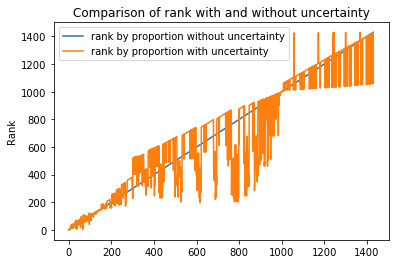

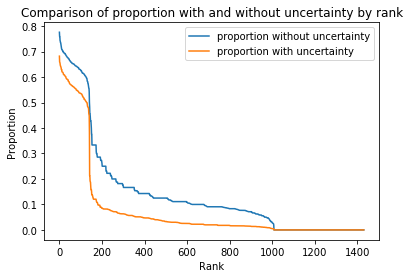

In [22]:
#Construct a list containing the data center ids that are sorted by their proportion, and set the index as the rank
waterErrorProportionRank = sorted(waterErrorProportionDict, key=waterErrorProportionDict.get, reverse=True)
waterErrorUncertaintyProportionRank = sorted(waterErrorUncertaintyProportionDict, key=waterErrorUncertaintyProportionDict.get, reverse=True)

#Store the rank with uncertainty on the corresponding index
UncertaintyProportionRankSortedByOrigin = []
for rankDataCenter in range(fileCount):
    UncertaintyProportionRankSortedByOrigin.append(waterErrorUncertaintyProportionRank.index(waterErrorProportionRank[rankDataCenter]))
    
rankList = []
for rank in range(0,fileCount):
    rankList.append(rank)
    
plt.plot(rankList, label="rank by proportion without uncertainty")
plt.plot(UncertaintyProportionRankSortedByOrigin, label="rank by proportion with uncertainty")
plt.title("Comparison of rank with and without uncertainty")
plt.ylabel("Rank")
plt.legend()
plt.show()

#Store the proportion of each rank into a list for the graph    
rankListProportion = []
rankListUncertaintyProportion = []
for rank in range(0,fileCount):
    rankListProportion.append(waterErrorProportionDict[waterErrorProportionRank[rank]])
    rankListUncertaintyProportion.append(waterErrorUncertaintyProportionDict[waterErrorUncertaintyProportionRank[rank]])

plt.plot(rankList, rankListProportion, label="proportion without uncertainty")
plt.plot(rankList, rankListUncertaintyProportion, label="proportion with uncertainty")
plt.title("Comparison of proportion with and without uncertainty by rank")
plt.xlabel("Rank")
plt.ylabel("Proportion")
plt.legend()
plt.show()


    